Contributors: Rohit Singh Rathaur, Girish L.

Copyright 2021 [Rohit Singh Rathaur, BIT Mesra and Girish L., CIT GUBBI, Karnataka]

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

In [ ]:
df_Ellis  = pd.read_csv("/content/drive/MyDrive/LFN Anuket/Analysis/data/Final/Ellis_FinalTwoConditionwithOR.csv")
df_Ellis

,Timestamp,ellis-cpu.system_perc,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-mem.free_mb,ellis-net.in_bytes_sec,ellis-net.out_packets_sec,Label
0,14-09-2016 0:00,0.5,12.9,1.730,3949,5413.200,62.067,1
1,14-09-2016 0:00,0.4,10.3,1.790,3950,5201.667,59.567,1
2,14-09-2016 0:01,0.4,11.8,1.520,3950,5370.733,61.200,1
3,14-09-2016 0:01,0.4,12.9,1.430,3949,5292.467,60.400,1
4,14-09-2016 0:02,0.5,12.1,1.440,3950,5318.167,61.700,1
...,...,...,...,...,...,...,...,...
176995,13-12-2016 21:20,0.4,0.3,0.030,3484,230.967,2.167,0
176996,13-12-2016 21:20,0.2,0.3,0.018,3484,218.433,0.767,0
176997,13-12-2016 21:21,0.6,0.3,0.010,3483,160.967,1.867,0
176998,13-12-2016 21:21,0.6,0.3,0.007,3484,188.367,2.100,0


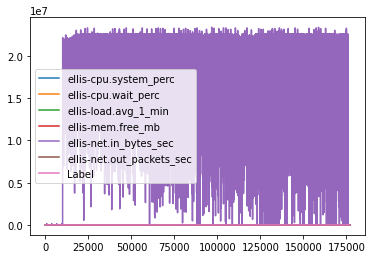

In [ ]:
df_Ellis.plot()

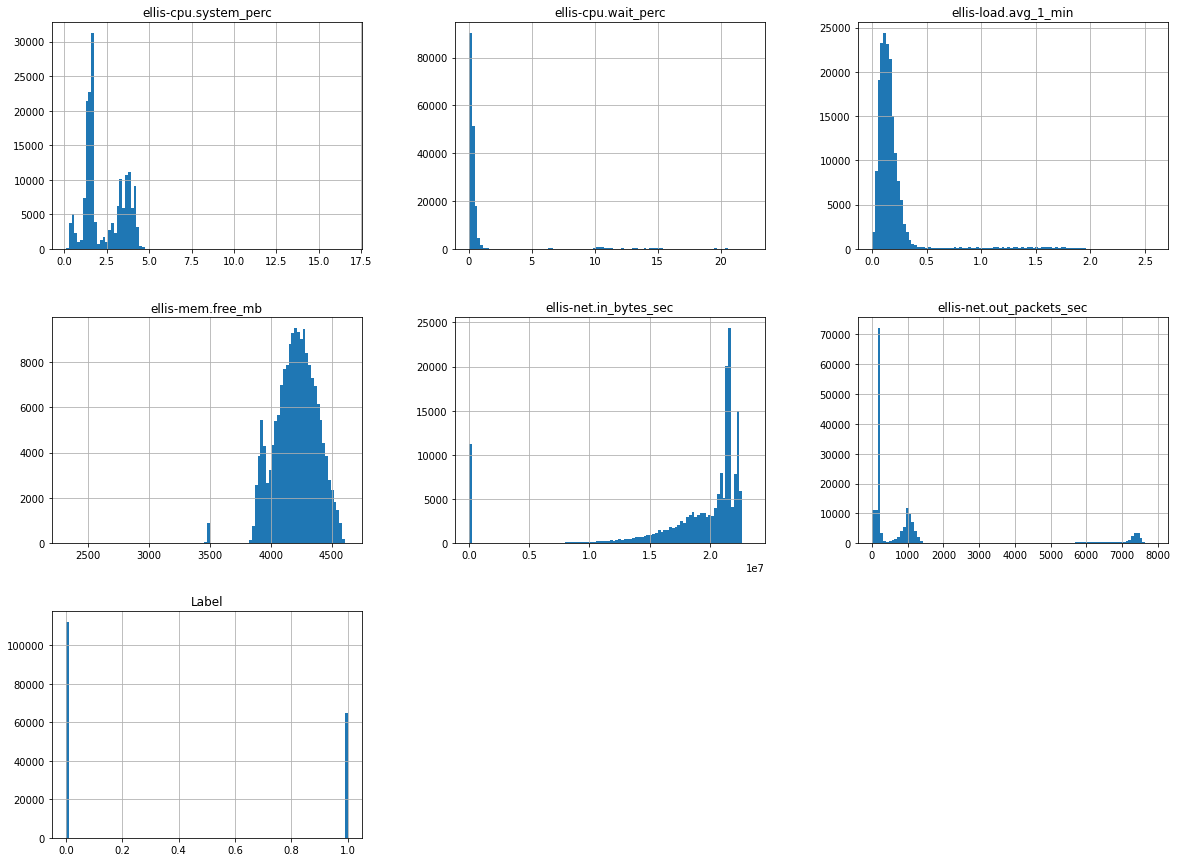

In [ ]:
# we show here the hist
df_Ellis.hist(bins=100,figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

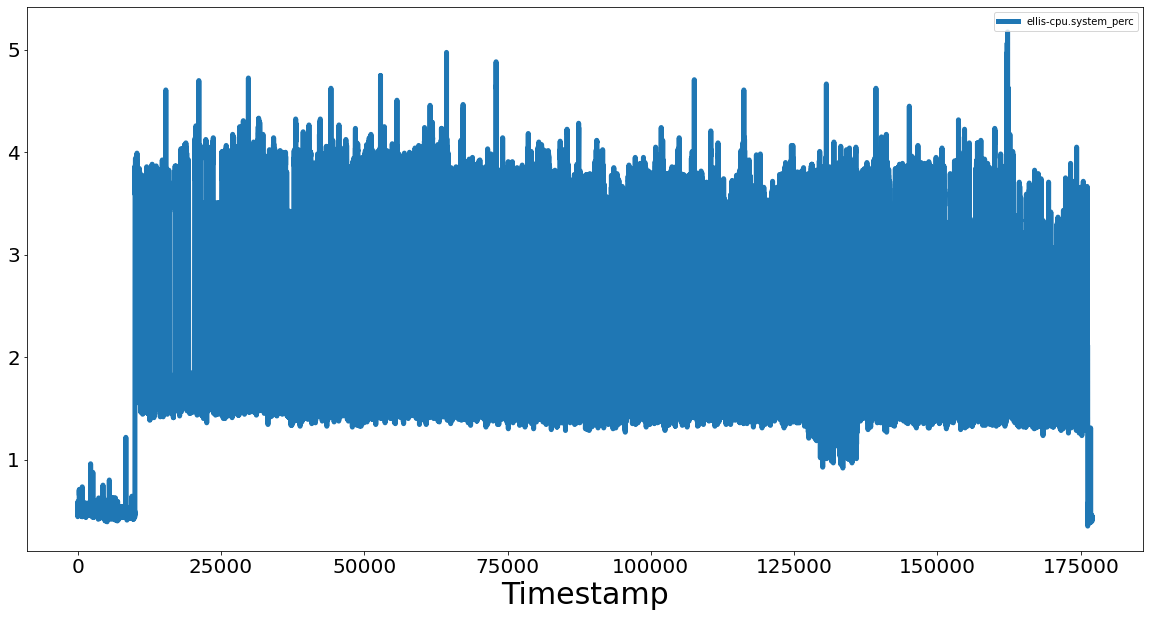

In [ ]:
cpu_system_perc = df_Ellis[['ellis-cpu.system_perc']] 
cpu_system_perc.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Timestamp', fontsize=30);

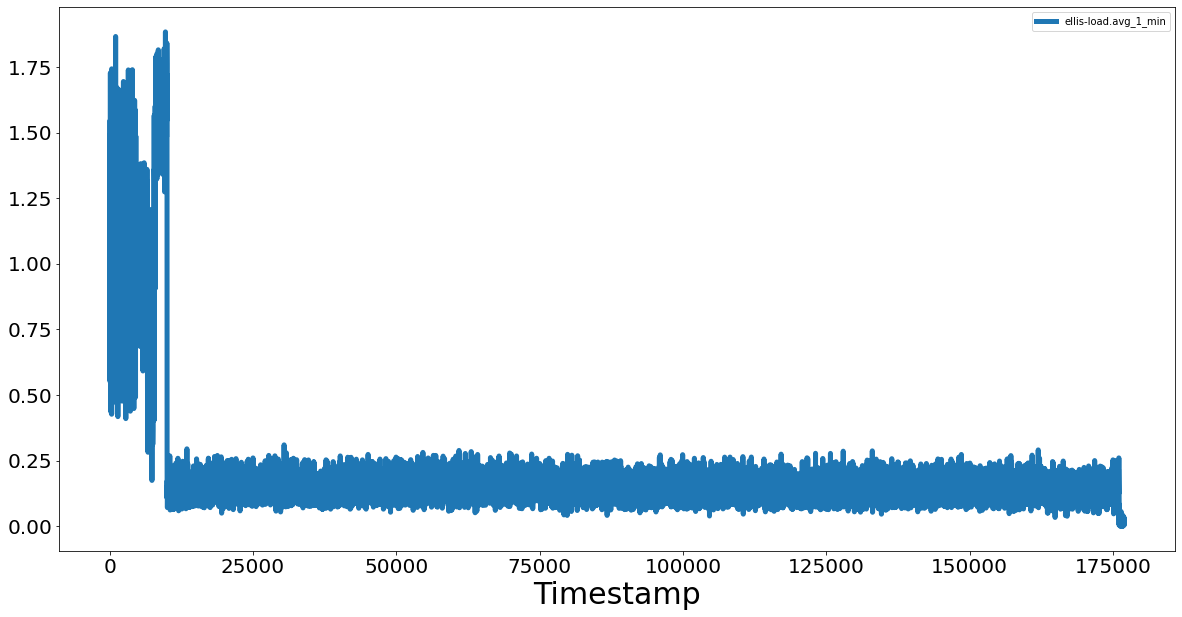

In [ ]:
load_avg_1_min = df_Ellis[['ellis-load.avg_1_min']] 
load_avg_1_min.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Timestamp', fontsize=30);

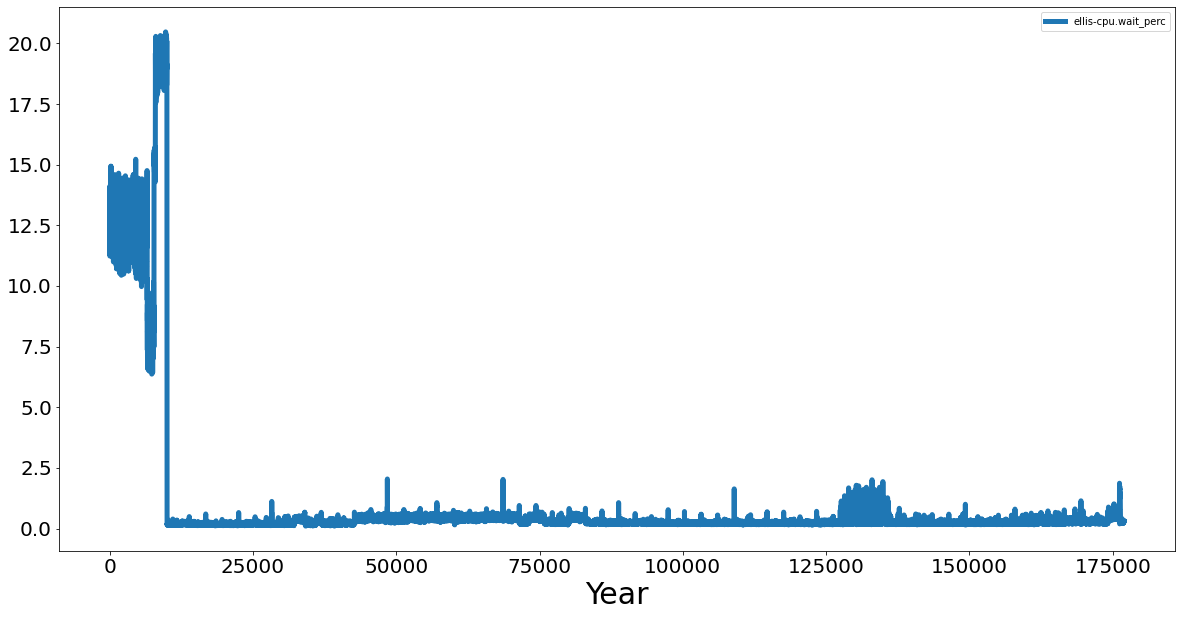

In [ ]:
cpu_wait_perc = df_Ellis[['ellis-cpu.wait_perc']] 
cpu_wait_perc.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Year', fontsize=30);

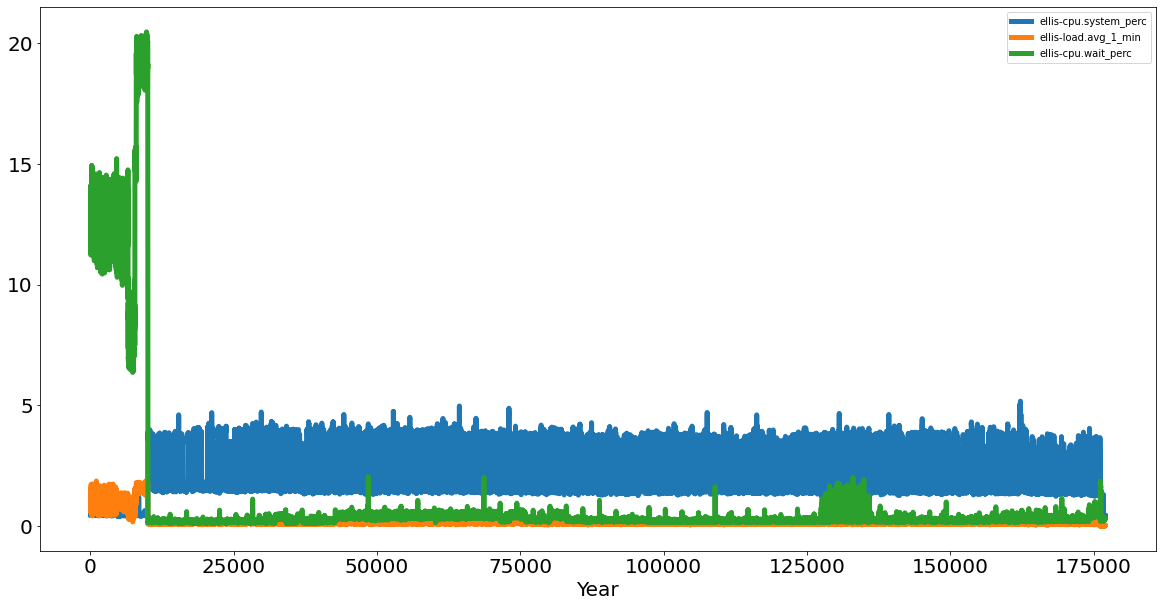

In [ ]:
df_dg = pd.concat([cpu_system_perc.rolling(12).mean(), load_avg_1_min.rolling(12).mean(),cpu_wait_perc.rolling(12).mean()], axis=1) 
df_dg.plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Year', fontsize=20); 

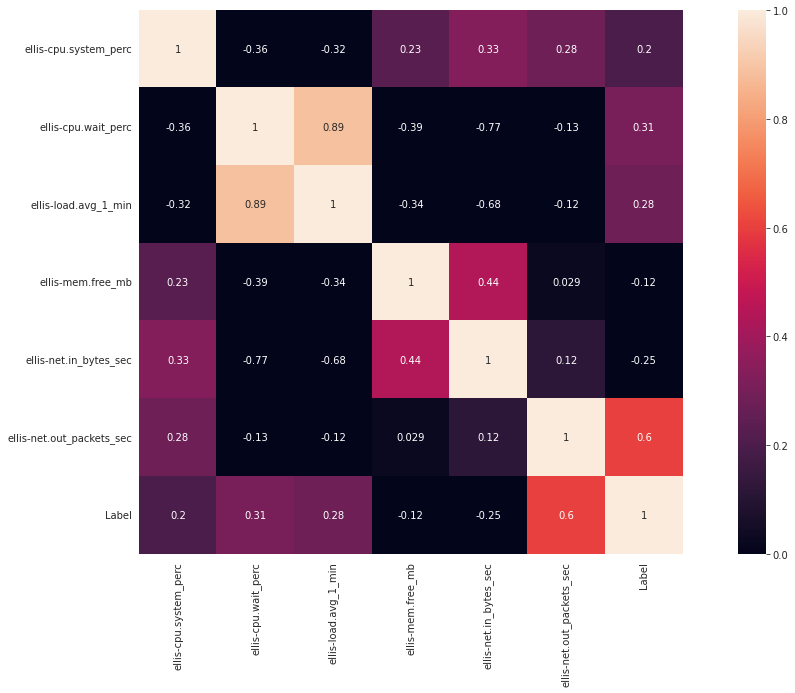

In [ ]:
# we establish the corrmartrice
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

correaltionMatrice = df_Ellis.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(correaltionMatrice, cbar=True, vmin=0, vmax=1, square=True, annot=True);
plt.show()

In [ ]:
df_Ellis.corrwith(df_Ellis['ellis-load.avg_1_min'])

ellis-cpu.system_perc       -0.316956
ellis-cpu.wait_perc          0.886739
ellis-load.avg_1_min         1.000000
ellis-mem.free_mb           -0.335300
ellis-net.in_bytes_sec      -0.681849
ellis-net.out_packets_sec   -0.116851
Label                        0.279330
dtype: float64

In [ ]:
## ## using multivariate feature 

features_3 = ['ellis-cpu.wait_perc', 'ellis-load.avg_1_min', 'ellis-net.in_bytes_sec', 'Label']

features = df_Ellis[features_3]
features.index = df_Ellis['Timestamp']
features.head()

,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-net.in_bytes_sec,Label
Timestamp,,,,
14-09-2016 0:00,12.9,1.73,5413.200,1
14-09-2016 0:00,10.3,1.79,5201.667,1
14-09-2016 0:01,11.8,1.52,5370.733,1
14-09-2016 0:01,12.9,1.43,5292.467,1
14-09-2016 0:02,12.1,1.44,5318.167,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5476b2bd0>,
      dtype=object)

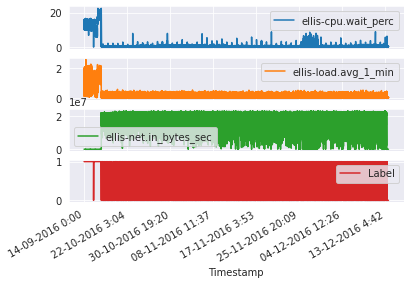

In [ ]:
features.plot(subplots=True)

In [ ]:
features = features.values

In [ ]:
### standardize data
train_split = 141600
tf.random.set_seed(13)

### standardize data
features_mean = features[:train_split].mean()
features_std = features[:train_split].std()
features  = (features - features_mean)/ features_std

print(type(features))
print(features.shape)


<class 'numpy.ndarray'>
(177000, 4)


In [ ]:
### create mutlivariate data

def mutlivariate_data(features , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(features)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(features[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [ ]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(features , features[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(features , features[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)
print(x_val_ss.shape , y_val_ss.shape)

(140880, 120, 4) (140880,)
(34608, 120, 4) (34608,)


In [ ]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>


In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout,Permute,Reshape,Lambda,dot,concatenate

INPUT_DIM = 100
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = True
APPLY_ATTENTION_BEFORE_LSTM = False

ATTENTION_SIZE = 128

def attention_3d_block(hidden_states):
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    # _t stands for transpose
    hidden_states_t =  Permute((2, 1), name='attention_input_t')(hidden_states)
    # hidden_states_t.shape = (batch_size, hidden_size, time_steps)
    # this line is not useful. It's just to know which dimension is what.
    hidden_states_t = Reshape((hidden_size, TIME_STEPS), name='attention_input_reshape')(hidden_states_t)
    # Inside dense layer
    # a (batch_size, hidden_size, time_steps) dot W (time_steps, time_steps) => (batch_size, hidden_size, time_steps)
    # W is the trainable weight matrix of attention
    # Luong's multiplicative style score
    score_first_part = Dense(TIME_STEPS, use_bias=False, name='attention_score_vec')(hidden_states_t)
    score_first_part_t = Permute((2, 1), name='attention_score_vec_t')(score_first_part)
    #            score_first_part_t         dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot (batch_size, hidden_size, 1) => (batch_size, time_steps, 1)
    h_t = Lambda(lambda x: x[:, :, -1], output_shape=(hidden_size, 1), name='last_hidden_state')(hidden_states_t)
    score = dot([score_first_part_t, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # if SINGLE_ATTENTION_VECTOR:
    #     a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    #     a = RepeatVector(hidden_size)(a)
    # (batch_size, hidden_size, time_steps) dot (batch_size, time_steps, 1) => (batch_size, hidden_size, 1)
    context_vector = dot([hidden_states_t, attention_weights], [2, 1], name='context_vector')
    context_vector = Reshape((hidden_size,))(context_vector)
    h_t = Reshape((hidden_size,))(h_t)
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(ATTENTION_SIZE, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [ ]:
from keras.layers import Activation, Dense, Dropout
from keras.layers import Input, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,Flatten
from keras.models import Model
from keras.utils.vis_utils import plot_model
### Modelling using LSTM
steps = 50
TIME_STEPS=120
INPUT_DIMS=4

EPOCHS =20

single_step_model = tf.keras.models.Sequential()

inputs = Input(shape=(120, 4))
lstm_units = 32
lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
lstm_out=tf.keras.layers.Dropout(0.6)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
#attention_mul = Flatten()(attention_mul)
attention_mul=tf.keras.layers.Dropout(0.6)(attention_mul)
output = Dense(1, activation='sigmoid')(attention_mul)

single_step_model = Model(inputs, output)

  
single_step_model.summary()

plot_model(single_step_model, to_file='/content/drive/MyDrive/LFN Anuket/Analysis/data/Final/LSTM-Attention-B.png', show_shapes=True, show_layer_names=True)

single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#single_step_model.compile(loss='mse', optimizer='rmsprop')

 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 120, 32)      4736        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 120, 32)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
attention_input_t (Permute)     (None, 32, 120)      0           dropout_2[0][0]                  
____________________________________________________________________________________________

In [ ]:
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)


Epoch 1/20
50/50 [==============================] - 10s 50ms/step - loss: 0.6677 - rmse: 0.6899 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 2/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5433 - rmse: 0.5433 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 3/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5432 - rmse: 0.5432 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 4/20
50/50 [==============================] - 2s 41ms/step - loss: 0.5432 - rmse: 0.5432 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 5/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5432 - rmse: 0.5432 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 6/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 7/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 8/20
50/50 [==============================] - 2s 40ms/step - l

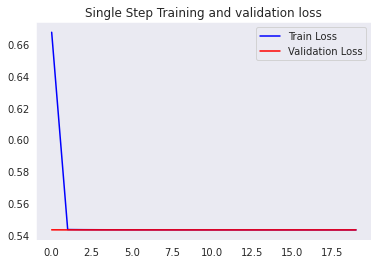

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

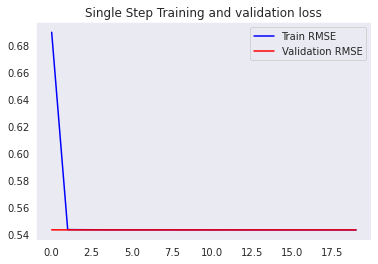

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['rmse']
  val_loss = history.history['val_rmse']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train RMSE')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation RMSE')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)

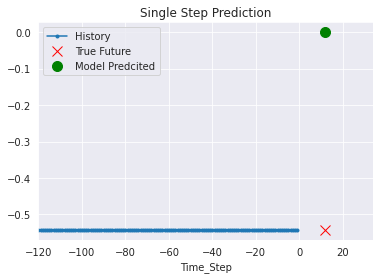

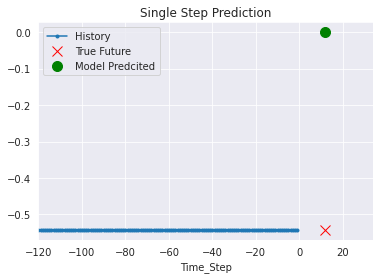

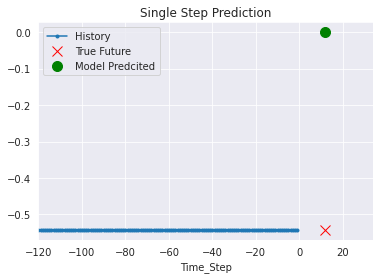

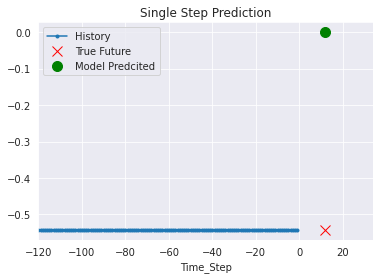

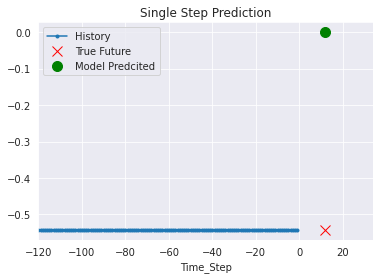

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# **MultiStep Forcasting**

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(features, features[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(features, features[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(140880, 120, 4)
(140880, 72)


In [ ]:
#  TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
print(train_data_multi)
print(val_data_multi)

<RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>


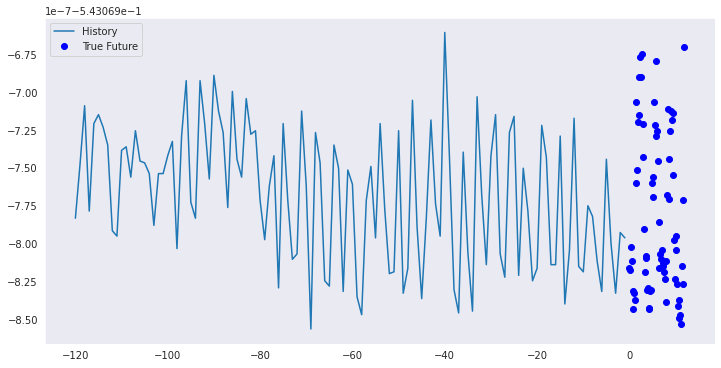

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()

inputs = Input(shape=(120, 4))
lstm_units = 32
lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
lstm_out=tf.keras.layers.Dropout(0.6)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
#attention_mul = Flatten()(attention_mul)
attention_mul=tf.keras.layers.Dropout(0.6)(attention_mul)
output = Dense(1, activation='sigmoid')(attention_mul)

multi_step_model = Model(inputs, output)
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
multi_step_model.summary()



Epoch 1/20
50/50 [==============================] - 5s 50ms/step - loss: 0.5863 - rmse: 0.5965 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 2/20
50/50 [==============================] - 2s 39ms/step - loss: 0.5432 - rmse: 0.5432 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 3/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 4/20
50/50 [==============================] - 2s 39ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 5/20
50/50 [==============================] - 2s 39ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 6/20
50/50 [==============================] - 2s 40ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 7/20
50/50 [==============================] - 2s 39ms/step - loss: 0.5431 - rmse: 0.5431 - val_loss: 0.5431 - val_rmse: 0.5431
Epoch 8/20
50/50 [==============================] - 2s 39ms/step - lo

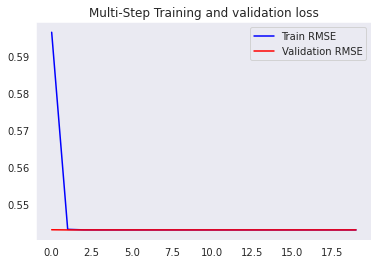

In [ ]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')

ValueError: ignored

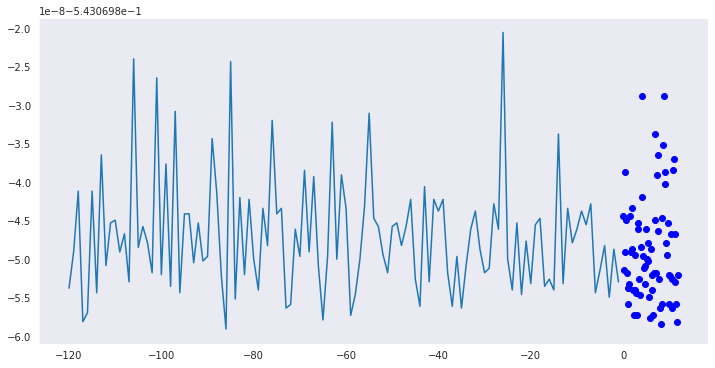

In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
scores = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))

In [ ]:
scores_test = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))


In [ ]:
y_pred_test = multi_step_model.predict(x_val_multi, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_pred_test)
plt.plot(y_val_multi)
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()